In [32]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import os
import threading

from six.moves import xrange
import scipy.io as sio
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf


# configuration
BATCH_SIZE = 100
NUM_SUBPLOT_COLS = 10
DATASET_PATH = "../data/train_32x32.mat"
VALID_DATASET_PATH = "./data/test_32x32.mat"
GEN_TEST_PATH = "../data/test_images.mat"
CROP_H = 24
CROP_W = 24
CROP_RATE = 0.75

NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 73257
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 100

class DataLoader:
  def __init__(self, data_path, batch_size=50, num_valid_samples=None):
    print("loading raw file:", data_path)
    data = sio.loadmat(data_path)
    self.images = data['X']
    self.labels = data['y']
    self.images = np.transpose(self.images, (3, 0, 1, 2))
    self.labels[self.labels==10] = 0
    self.num_valid_samples = num_valid_samples
    self.batch_size = num_valid_samples or batch_size
    if self.num_valid_samples != None:
      self.random_valid_set()
    # create queue
    print("filling input queue")
    self.queue_image = tf.placeholder(tf.int64, shape=[self.batch_size, 32, 32, 3], name="input_images")
    self.queue_label = tf.placeholder(tf.int64, shape=[self.batch_size, 1], name="input_labels")
    if self.num_valid_samples == None:
      capacity=int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * 0.4) + 3 * self.batch_size
      self.example_queue = tf.FIFOQueue(
        capacity=capacity,
        dtypes=[tf.int64, tf.int64],
        shapes=[[32, 32, 3], [1]])
      self.enqueue = self.example_queue.enqueue_many([self.queue_image, self.queue_label])
      self.enqueue_thread = None
      self.coord = tf.train.Coordinator()
      self.threads = None

  def random_valid_set(self):
    num_valid_samples = self.num_valid_samples
    dataset_size = self.images.shape[0]
    start = np.random.randint(0, dataset_size - num_valid_samples)
    self.images = self.images[start:start+num_valid_samples]
    self.labels = self.labels[start:start+num_valid_samples]
    print("random validation set [%d:%d]" % (start, start+num_valid_samples))
    
  def data_stream(self, session):
    start = 0
    dataset_size = len(self.labels)
    while not self.coord.should_stop():
      end = start + self.batch_size
      # print("loading [%d:%d] into input queue..." % (start, end))
      if end <= dataset_size:
        image_batch = self.images[start:end]
        label_batch = self.labels[start:end]
        start = end
      else:
        remaining = end - dataset_size
        image_batch = np.concatenate((self.images[start:dataset_size], self.images[0:remaining]))
        label_batch = np.concatenate((self.labels[start:dataset_size], self.labels[0:remaining]))
        start = remaining
      session.run(
        self.enqueue, 
        feed_dict={
          self.queue_image : image_batch,
          self.queue_label : label_batch})
    print("data stream closed.")

  def preprocess(self):
    image, label = self.example_queue.dequeue()
    image = tf.image.central_crop(image, CROP_RATE)
    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    float_image = tf.image.per_image_standardization(distorted_image)
    return float_image, label

  def load_batch(self):
    if self.num_valid_samples == None:
      image, label= self.preprocess()
      image.set_shape([32 * CROP_RATE, 32 * CROP_RATE, 3])
      label.set_shape([1])
      image_batch, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=self.batch_size,
        num_threads=4,
        capacity=int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * 0.4) + 3 * self.batch_size,
        min_after_dequeue=int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * 0.4))
    else:
      '''
      image_batch, label_batch = tf.train.batch(
        [image, label],
        batch_size=self.batch_size,
        num_threads=4,
        capacity=int(self.num_valid_samples * 0.4) + 3 * self.batch_size)
      '''
      image_batch = []
      label_batch = []
      for i in range(self.num_valid_samples):
        image_batch.append(tf.stack(self.images[i]))
        image_batch[i] = tf.image.central_crop(image_batch[i], CROP_RATE)
        image_batch[i] = tf.image.per_image_standardization(image_batch[i])
        label_batch.append(tf.cast(tf.stack(self.labels[i]), dtype=tf.int32))
      image_batch = tf.stack(image_batch)
      label_batch = tf.stack(label_batch)

    # tf.summary.image('images', image_batch)
    print("loading batch of samples:", self.batch_size) 
    return image_batch, tf.reshape(label_batch, [self.batch_size])

  def load(self, session):
    self.enqueue_thread = threading.Thread(target=self.data_stream, args=[session])
    self.enqueue_thread.isDaemon()
    self.enqueue_thread.start()
    self.threads = tf.train.start_queue_runners(coord=self.coord, sess=session)
    
  def close(self, session):
    session.run(self.example_queue.close(cancel_pending_enqueues=True))
    self.coord.request_stop()
    self.coord.join(self.threads)
    print("dataloader closed successfully.")




loading raw file: ./data/test_32x32.mat
random validation set [8724:8824]
filling input queue
loading batch of samples: 100
(100, 24, 24, 3) (100,)
[2 8 4 7 6 8 5 2 3 7]
[7 2 2 7 0 7 3 2 1 7]
[0 2 0 5 4 0 2 2 6 1]
[8 3 7 0 1 7 4 3 3 0]
[2 0 2 1 5 4 6 4 1 7]
[1 2 3 5 2 2 1 4 4 6]
[7 3 6 4 1 4 6 2 1 7]
[2 3 2 1 9 2 5 6 5 8]
[4 0 7 5 8 2 7 0 8 6]
[4 9 6 3 5 6 2 4 8 1]


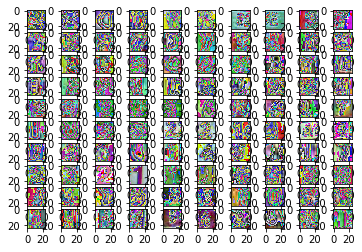

In [33]:
if __name__ == "__main__":
  fig = plt.figure()
  num_valid_samples = NUM_EXAMPLES_PER_EPOCH_FOR_EVAL
  num_plot_cols = NUM_SUBPLOT_COLS
  num_plot_rows = int(math.ceil(num_valid_samples/num_plot_cols))
  labels = []

  with tf.Graph().as_default():
    dataloader = DataLoader(VALID_DATASET_PATH, num_valid_samples=num_valid_samples)
    image_batch, label_batch = dataloader.load_batch()
    run_options = tf.RunOptions(timeout_in_ms=4000000)
    with tf.Session() as session:
      images, labels = session.run([image_batch, label_batch], options=run_options)
      print(images.shape, labels.shape)
      for row in range(num_plot_rows):
        print(labels[row*num_plot_cols:(row+1)*num_plot_cols])
      for batch_i in range(num_valid_samples):
        sub_plot = fig.add_subplot(num_plot_rows, num_plot_cols, batch_i+1)
        plt.imshow(images[batch_i])
  plt.show()


loading raw file: ./data/test_32x32.mat
filling input queue
loading batch of samples: 100
(100, 24, 24, 3) (100,)
[4 0 6 1 6 2 3 7 2 0]
[5 5 8 8 7 5 7 2 0 6]
[4 3 1 5 8 8 1 1 1 1]
[3 8 1 4 3 1 5 0 8 6]
[1 1 3 1 0 2 5 2 7 5]
[9 9 7 6 1 4 2 1 6 5]
[3 1 4 9 2 7 2 0 1 6]
[7 1 7 6 7 4 3 2 0 3]
[4 4 1 5 5 5 3 3 1 2]
[6 7 1 8 2 3 9 0 2 1]


Exception in thread Thread-89:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-32-c838e1a0e0f0>", line 84, in data_stream
    self.queue_label : label_batch})
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/client/session.py", line 767, in run
    run_metadata_ptr)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/client/session.py", line 965, in _run
    feed_dict_string, options, run_metadata)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/client/session.py", line 1015, in _do_run
    target_list, options, run_metadata)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/client/session.py", line 1035, in _do_call
    raise type(e)(node_def, op, message)
CancelledError: Enqueue operation was cancelled
	 [[Node: fifo_queu

dataloader closed successfully.


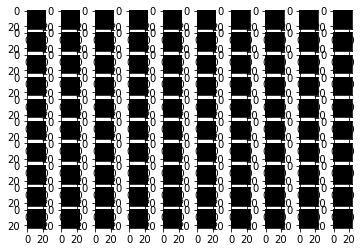

In [34]:
if __name__ == "__main__":
  fig = plt.figure()
  num_valid_samples = BATCH_SIZE
  num_plot_cols = NUM_SUBPLOT_COLS
  num_plot_rows = int(math.ceil(num_valid_samples/num_plot_cols))
  labels = []

  with tf.Graph().as_default():
    dataloader = DataLoader(VALID_DATASET_PATH, BATCH_SIZE)
    image_batch, label_batch = dataloader.load_batch()
    run_options = tf.RunOptions(timeout_in_ms=4000000)
    with tf.Session() as session:
      dataloader.load(session)
      images, labels = session.run([image_batch, label_batch], options=run_options)
      print(images.shape, labels.shape)
      for row in range(num_plot_rows):
        print(labels[row*num_plot_cols:(row+1)*num_plot_cols])
      for batch_i in range(num_valid_samples):
        sub_plot = fig.add_subplot(num_plot_rows, num_plot_cols, batch_i+1)
        plt.imshow(images[batch_i])
      dataloader.close(session)
  plt.show()
